# Линейная регрессия и основные библиотеки Python для анализа данных и научных вычислений

Это задание посвящено линейной регрессии. На примере прогнозирования роста человека по его весу Вы увидите, какая математика за этим стоит, а заодно познакомитесь с основными библиотеками Python, необходимыми для дальнейшего прохождения курса.

## Задание 1. Первичный анализ данных c Pandas

В этом заданиии мы будем использовать данные [SOCR](http://wiki.stat.ucla.edu/socr/index.php/SOCR_Data_Dinov_020108_HeightsWeights) по росту и весу 25 тысяч подростков.

**[1].** Если у Вас не установлена библиотека Seaborn - выполните в терминале команду *conda install seaborn*. (Seaborn не входит в сборку Anaconda, но эта библиотека предоставляет удобную высокоуровневую функциональность для визуализации данных).

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from functools import partial
from scipy import optimize
%matplotlib inline

Считаем данные по росту и весу (*weights_heights.csv*, приложенный в задании) в объект Pandas DataFrame:

In [2]:
data = pd.read_csv('weights_heights.csv', index_col='Index')

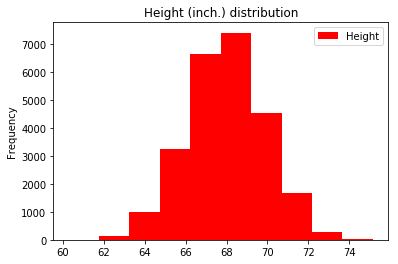

In [3]:
data.plot(y='Height', kind='hist', 
           color='red',  title='Height (inch.) distribution')
plt.show()

**[2]**. Посмотрите на первые 5 записей с помощью метода *head* Pandas DataFrame. Нарисуйте гистограмму распределения веса с помощью метода *plot* Pandas DataFrame. Сделайте гистограмму зеленой, подпишите картинку.

In [4]:
data.head(5)

,Height,Weight
Index,,
1,65.78331,112.9925
2,71.51521,136.4873
3,69.39874,153.0269
4,68.21660,142.3354
5,67.78781,144.2971


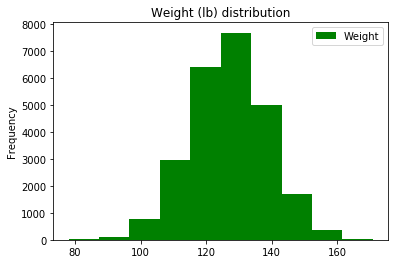

In [5]:
data.plot(y='Weight', kind='hist', 
           color='green',  title='Weight (lb) distribution')
plt.show()

Один из эффективных методов первичного анализа данных - отображение попарных зависимостей признаков. Создается $m \times m$ графиков (*m* - число признаков), где по диагонали рисуются гистограммы распределения признаков, а вне диагонали - scatter plots зависимости двух признаков. Это можно делать с помощью метода $scatter\_matrix$ Pandas Data Frame или *pairplot* библиотеки Seaborn. 

Чтобы проиллюстрировать этот метод, интересней добавить третий признак. Создадим признак *Индекс массы тела* ([BMI](https://en.wikipedia.org/wiki/Body_mass_index)). Для этого воспользуемся удобной связкой метода *apply* Pandas DataFrame и lambda-функций Python.

In [6]:
def make_bmi(height_inch, weight_pound):
    METER_TO_INCH, KILO_TO_POUND = 39.37, 2.20462
    return (weight_pound / KILO_TO_POUND) / \
           (height_inch / METER_TO_INCH) ** 2

In [7]:
data['BMI'] = data.apply(lambda row: make_bmi(row['Height'], 
                                              row['Weight']), axis=1)

**[3].** Постройте картинку, на которой будут отображены попарные зависимости признаков , 'Height', 'Weight' и 'BMI' друг от друга. Используйте метод *pairplot* библиотеки Seaborn.

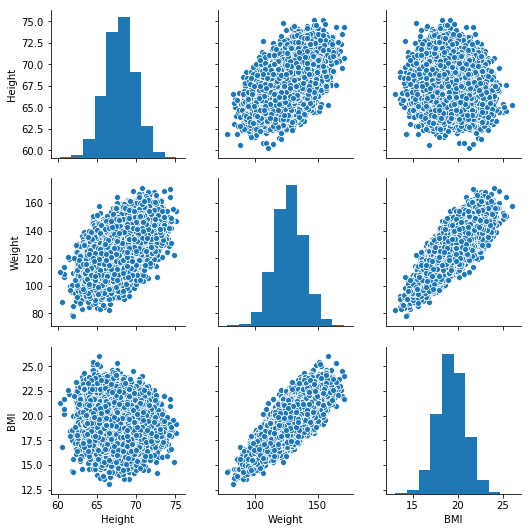

In [8]:
sns.pairplot(data)
plt.show()

**[4]**. Создайте в DataFrame *data* новый признак *weight_category*, который будет иметь 3 значения: 1 – если вес меньше 120 фунтов. (~ 54 кг.), 3 - если вес  больше или равен 150 фунтов (~68 кг.), 2 – в остальных случаях. Постройте «ящик с усами» (boxplot), демонстрирующий зависимость роста от весовой категории. Используйте метод *boxplot* библиотеки Seaborn и метод *apply* Pandas DataFrame. Подпишите ось *y* меткой «Рост», ось *x* – меткой «Весовая категория».

In [9]:
def weight_category(weight):
    if weight < 120:
        return 1
    elif weight >= 150:
        return 3
    else:
        return 2

data['weight_cat'] = data['Weight'].apply(weight_category)

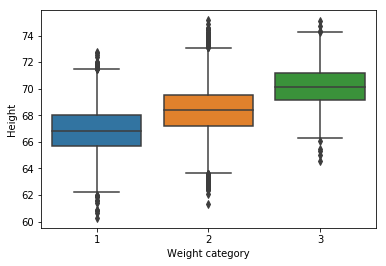

In [10]:
sns.boxplot(y="Height", x="weight_cat", data=data)
plt.xlabel('Weight category');
plt.ylabel('Height')
plt.show()

**[5].** Постройте scatter plot зависимости роста от веса, используя метод *plot* для Pandas DataFrame с аргументом *kind='scatter'*. Подпишите картинку.

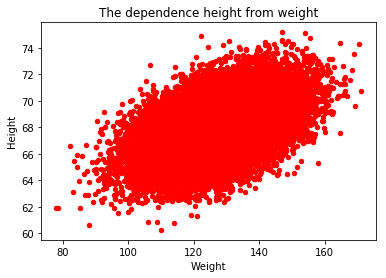

In [11]:
data.plot(y='Height',x = 'Weight', kind='scatter', 
           color='red',  title='The dependence height from weight')
plt.show()

## Задание 2. Минимизация квадратичной ошибки

В простейшей постановке задача прогноза значения вещественного признака по прочим признакам (задача восстановления регрессии) решается минимизацией квадратичной функции ошибки. 

**[6].** Напишите функцию, которая по двум параметрам $w_0$ и $w_1$ вычисляет квадратичную ошибку приближения зависимости роста $y$ от веса $x$ прямой линией $y = w_0 + w_1 * x$:
$$error(w_0, w_1) = \sum_{i=1}^n {(y_i - (w_0 + w_1 * x_i))}^2 $$
Здесь $n$ – число наблюдений в наборе данных, $y_i$ и $x_i$ – рост и вес $i$-ого человека в наборе данных. 

In [12]:
def SE(w0,w1,sample = data):
    error = 0
    for row in sample.itertuples():
        error += (row[1] - w0 - w1 * row[2])**2
    return error

Итак, мы решаем задачу: как через облако точек, соответсвующих наблюдениям в нашем наборе данных, в пространстве признаков "Рост" и "Вес" провести прямую линию так, чтобы минимизировать функционал из п. 6. Для начала давайте отобразим хоть какие-то прямые и убедимся, что они плохо передают зависимость роста от веса.

**[7].** Проведите на графике из п. 5 Задания 1 две прямые, соответствующие значениям параметров ($w_0, w_1) = (60, 0.05)$ и ($w_0, w_1) = (50, 0.16)$. Используйте метод *plot* из *matplotlib.pyplot*, а также метод *linspace* библиотеки NumPy. Подпишите оси и график.

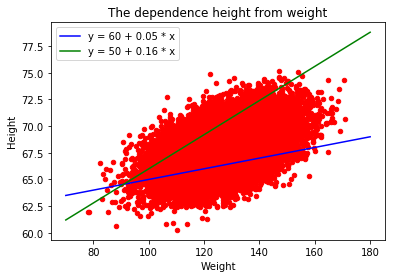

In [13]:
arguments = np.linspace(70,180,1000)
y1 = list(map(lambda x: 60 + 0.05 * x, arguments))
y2 = list(map(lambda x: 50 + 0.16 * x, arguments))
data.plot(y='Height',x = 'Weight', kind='scatter', 
           color='red',  title='The dependence height from weight')
plt.plot(arguments, y1,'b', label='y = 60 + 0.05 * x');
plt.plot(arguments, y2,'g', label='y = 50 + 0.16 * x');
plt.legend()
plt.show()

Минимизация квадратичной функции ошибки - относительная простая задача, поскольку функция выпуклая. Для такой задачи существует много методов оптимизации. Посмотрим, как функция ошибки зависит от одного параметра (наклон прямой), если второй параметр (свободный член) зафиксировать.

**[8].** Постройте график зависимости функции ошибки, посчитанной в п. 6, от параметра $w_1$ при $w_0$ = 50. Подпишите оси и график.

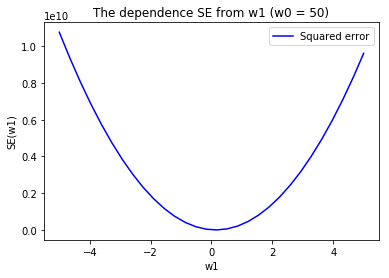

In [14]:
arguments = np.linspace(-5,5,30)
y = list(map(partial(SE, 50),arguments))
plt.plot(arguments, y,'b', label='Squared error');
plt.xlabel('w1');
plt.ylabel('SE(w1)')
plt.title('The dependence SE from w1 (w0 = 50)')
plt.legend()
plt.show()

Теперь методом оптимизации найдем "оптимальный" наклон прямой, приближающей зависимость роста от веса, при фиксированном коэффициенте $w_0 = 50$.

**[9].** С помощью метода *minimize_scalar* из *scipy.optimize* найдите минимум функции, определенной в п. 6, для значений параметра  $w_1$ в диапазоне [-5,5]. Проведите на графике из п. 5 Задания 1 прямую, соответствующую значениям параметров ($w_0$, $w_1$) = (50, $w_1\_opt$), где $w_1\_opt$ – найденное в п. 8 оптимальное значение параметра $w_1$. 

In [15]:
w1_opt = optimize.minimize_scalar(partial(SE, 50), bounds = (-5, 5),
                                  method = 'bounded').x

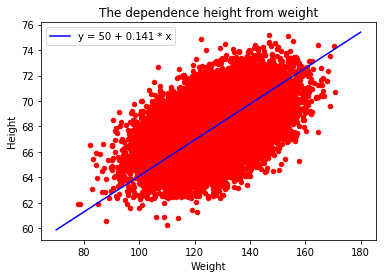

In [16]:
data.plot(y='Height',x = 'Weight', kind='scatter', 
           color='red',  title='The dependence height from weight')
arguments = np.linspace(70,180,1000)
y_opt = list(map(lambda x: 50 + w1_opt * x, arguments))
plt.plot(arguments, y_opt,'b', label='y = 50 + '+ str(round(w1_opt,3)) +' * x');
plt.legend()
plt.show()

**[10].** Постройте 3D-график зависимости функции ошибки, посчитанной в п.6 от параметров $w_0$ и $w_1$. Подпишите ось $x$ меткой «Intercept», ось $y$ – меткой «Slope», a ось $z$ – меткой «Error».

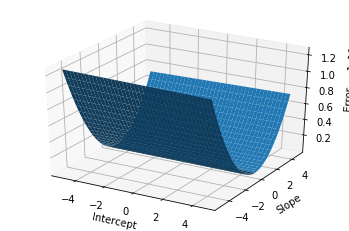

In [17]:
fig = plt.figure()
ax = fig.gca(projection='3d') # get current axis

X = np.arange(-5, 5, 0.25)
Y = np.arange(-5, 5, 0.25)
X, Y = np.meshgrid(X, Y)
Z = SE(X,Y)

surf = ax.plot_surface(X, Y, Z)
ax.set_xlabel('Intercept')
ax.set_ylabel('Slope')
ax.set_zlabel('Error')
plt.show()

**[11].** С помощью метода *minimize* из scipy.optimize найдите минимум функции, определенной в п. 6, для значений параметра $w_0$ в диапазоне [-100,100] и $w_1$ - в диапазоне [-5, 5]. Начальная точка – ($w_0$, $w_1$) = (0, 0). Используйте метод оптимизации L-BFGS-B (аргумент method метода minimize). Проведите на графике из п. 5 Задания 1 прямую, соответствующую найденным оптимальным значениям параметров $w_0$ и $w_1$. Подпишите оси и график.

In [20]:
SE_OneArg = lambda w: SE(w[0], w[1])
SE_OneArg()
w0_op, w1_op = optimize.minimize(SE_OneArg, x0 =(0,0) ,
                                 method = 'L-BFGS-B',
                                 bounds = [(-100,100),(-5,5)]).x

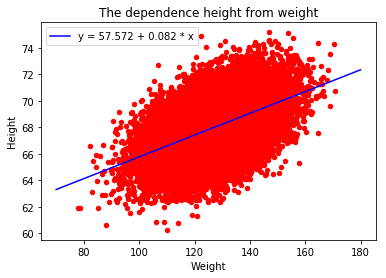

In [19]:
data.plot(y='Height',x = 'Weight', kind='scatter', 
           color='red',  title='The dependence height from weight')
arguments = np.linspace(70,180,1000)
y_opt = list(map(lambda x: w0_op + w1_op * x, arguments))
plt.plot(arguments, y_opt,'b',
         label='y = {} + {} * x'.format(round(w0_op, 3),round(w1_op, 3)));
plt.legend()
plt.show()

## Критерии оценки работы

- Выполняется ли тетрадка IPython без ошибок? (15 баллов)
- Верно ли отображена гистограмма распределения роста из п. 2? (3 балла). Правильно ли оформлены подписи? (1 балл)
- Верно ли отображены попарные зависимости признаков из п. 3? (3 балла). Правильно ли оформлены подписи? (1 балл)
- Верно ли отображена зависимость роста от весовой категории из п. 4? (3 балла). Правильно ли оформлены подписи? (1 балл)
- Верно ли отображен scatter plot роста от веса из п. 5? (3 балла). Правильно ли оформлены подписи? (1 балл)
- Правильно ли реализована функция подсчета квадратичной ошибки из п. 6? (10 баллов)
- Правильно ли нарисован график из п. 7? (3 балла) Правильно ли оформлены подписи? (1 балл)
- Правильно ли нарисован график из п. 8? (3 балла) Правильно ли оформлены подписи? (1 балл)
- Правильно ли используется метод minimize\_scalar из scipy.optimize? (6 баллов). Правильно ли нарисован график из п. 9? (3 балла) Правильно ли оформлены подписи? (1 балл)
- Правильно ли нарисован 3D-график из п. 10? (6 баллов) Правильно ли оформлены подписи? (1 балл)
- Правильно ли используется метод minimize из scipy.optimize? (6 баллов). Правильно ли нарисован график из п. 11? (3 балла). Правильно ли оформлены подписи? (1 балл)

### Work has been verified